1. **Checking** GPU integration.


In [1]:
!nvidia-smi



Sun Jan 18 05:51:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2. Mounting FALCON DATASET


In [10]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd Offroad_Segmentation_Training_Dataset
!ls


[Errno 2] No such file or directory: 'Offroad_Segmentation_Training_Dataset'
/content
drive  sample_data


In [5]:
%cd Offroad_Segmentation_Training_Dataset
!ls

[Errno 2] No such file or directory: 'Offroad_Segmentation_Training_Dataset'
/content
drive  sample_data


In [9]:
!ls train


ls: cannot access 'train': No such file or directory


In [12]:
# Go to the dataset root (you are already here, but ensure)
%cd /content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


In [13]:
!ls train
!ls val


images	masks
images	masks


In [14]:
!ls train/images | head
!ls train/masks | head


cc0000012.png
cc0000013.png
cc0000014.png
cc0000015.png
cc0000017.png
cc0000018.png
cc0000021.png
cc0000022.png
cc0000023.png
cc0000025.png
cc0000012.png
cc0000013.png
cc0000014.png
cc0000015.png
cc0000017.png
cc0000018.png
cc0000021.png
cc0000022.png
cc0000023.png
cc0000025.png


In [15]:
!pwd


/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset


Imports and environment


In [16]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [17]:
print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Dataset Paths


In [18]:
BASE_PATH = "/content/drive/MyDrive/Offroad_Segmentation_Training_Dataset/Offroad_Segmentation_Training_Dataset"

train_images = os.path.join(BASE_PATH, "train/images")
train_masks  = os.path.join(BASE_PATH, "train/masks")

val_images = os.path.join(BASE_PATH, "val/images")
val_masks  = os.path.join(BASE_PATH, "val/masks")

print("Train images:", len(os.listdir(train_images)))
print("Train masks :", len(os.listdir(train_masks)))
print("Val images  :", len(os.listdir(val_images)))
print("Val masks   :", len(os.listdir(val_masks)))


Train images: 2857
Train masks : 2857
Val images  : 317
Val masks   : 317


In [22]:
# Raw dataset class IDs → model class indices
CLASS_MAP = {
    100: 0,    # Trees
    200: 1,    # Lush Bushes
    300: 2,    # Dry Grass
    500: 3,    # Dry Bushes
    550: 4,    # Ground Clutter
    600: 5,    # Flowers
    700: 6,    # Logs
    800: 7,    # Rocks
    7100: 8,   # Landscape
    10000: 9  # Sky
}


Data Generator



In [23]:
def data_generator(img_dir, mask_dir):
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    while True:
        for i in range(0, len(img_files), BATCH_SIZE):
            images = []
            masks = []

            for j in range(i, min(i + BATCH_SIZE, len(img_files))):
                # --- Image ---
                img = tf.keras.preprocessing.image.load_img(
                    os.path.join(img_dir, img_files[j]),
                    target_size=(IMG_SIZE, IMG_SIZE)
                )
                img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

                # --- Mask ---
                mask = tf.keras.preprocessing.image.load_img(
                    os.path.join(mask_dir, mask_files[j]),
                    target_size=(IMG_SIZE, IMG_SIZE),
                    color_mode="grayscale"
                )
                mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.int32)
                mask = mask.squeeze()

                # Map raw IDs → 0–9
                mapped_mask = np.zeros_like(mask)
                for raw_id, cls_id in CLASS_MAP.items():
                    mapped_mask[mask == raw_id] = cls_id

                mapped_mask = tf.keras.utils.to_categorical(mapped_mask, NUM_CLASSES)

                images.append(img)
                masks.append(mapped_mask)

            yield np.array(images), np.array(masks)


Creating Generators

In [24]:
train_gen = data_generator(train_images, train_masks)
val_gen   = data_generator(val_images, val_masks)


In [25]:
images, masks = next(train_gen)

print(images.shape)
print(masks.shape)
print("Unique classes:", np.unique(np.argmax(masks[0], axis=-1)))


(4, 256, 256, 3)
(4, 256, 256, 10)
Unique classes: [1 2 3 4 7 8 9]


DeeplabV3 encoder

In [26]:
def ASPP(x, filters=256):
    shape = x.shape

    y1 = layers.Conv2D(filters, 1, padding="same", use_bias=False)(x)
    y1 = layers.BatchNormalization()(y1)
    y1 = layers.ReLU()(y1)

    y2 = layers.Conv2D(filters, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y2 = layers.BatchNormalization()(y2)
    y2 = layers.ReLU()(y2)

    y3 = layers.Conv2D(filters, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y3 = layers.BatchNormalization()(y3)
    y3 = layers.ReLU()(y3)

    y4 = layers.Conv2D(filters, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y4 = layers.BatchNormalization()(y4)
    y4 = layers.ReLU()(y4)

    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y5)
    y5 = layers.BatchNormalization()(y5)
    y5 = layers.ReLU()(y5)
    y5 = layers.UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y5)

    y = layers.Concatenate()([y1, y2, y3, y4, y5])
    y = layers.Conv2D(filters, 1, padding="same", use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    return y


resnet backbone

In [27]:
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Encoder output
encoder_output = base_model.get_layer("conv4_block6_out").output


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [28]:
aspp_output = ASPP(encoder_output)


Attention Gates

In [29]:
def attention_gate(x, g, inter_channels):
    """
    x: skip connection (from encoder)
    g: gating signal (from decoder)
    """

    theta_x = layers.Conv2D(inter_channels, 1, padding="same")(x)
    phi_g   = layers.Conv2D(inter_channels, 1, padding="same")(g)

    add = layers.Add()([theta_x, phi_g])
    add = layers.ReLU()(add)

    psi = layers.Conv2D(1, 1, padding="same")(add)
    psi = layers.Activation("sigmoid")(psi)

    return layers.Multiply()([x, psi])


In [30]:
low_level_feat = base_model.get_layer("conv2_block3_out").output
low_level_feat = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
low_level_feat = layers.BatchNormalization()(low_level_feat)
low_level_feat = layers.ReLU()(low_level_feat)


In [31]:
aspp_upsampled = layers.UpSampling2D(
    size=(4, 4),
    interpolation="bilinear"
)(aspp_output)


In [32]:
attended_skip = attention_gate(
    low_level_feat,
    aspp_upsampled,
    inter_channels=48
)


In [33]:
decoder = layers.Concatenate()([aspp_upsampled, attended_skip])

decoder = layers.Conv2D(256, 3, padding="same", use_bias=False)(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.ReLU()(decoder)

decoder = layers.Conv2D(256, 3, padding="same", use_bias=False)(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.ReLU()(decoder)


In [34]:
decoder = layers.UpSampling2D(
    size=(4, 4),
    interpolation="bilinear"
)(decoder)

outputs = layers.Conv2D(
    NUM_CLASSES,
    1,
    activation="softmax"
)(decoder)


In [35]:
model = models.Model(
    inputs=base_model.input,
    outputs=outputs
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,847,259 (68.08 MB)

 Trainable params: 17,812,475 (67.95 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [36]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)


In [37]:
def dice_ce_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    d  = dice_loss(y_true, y_pred)
    return ce + d


In [38]:
for layer in base_model.layers:
    layer.trainable = False


In [43]:
mean_iou_metric = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)


In [44]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_ce_loss,
    metrics=[mean_iou_metric]
)


In [45]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/deeplab_att_unet_v3_best.h5",
        monitor="val_loss",
        save_best_only=True
    )
]


In [46]:
history = model.fit(
    train_gen,
    steps_per_epoch=30,
    validation_data=val_gen,
    validation_steps=10,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 2.5076 - mean_io_u_2: 0.4500

30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 8s/step - loss: 2.4964 - mean_io_u_2: 0.4500 - val_loss: 3.0135 - val_mean_io_u_2: 0.4500
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.3271 - mean_io_u_2: 0.4500

30/30 ━━━━━━━━━━━━━━━━━━━━ 214s 7s/step - loss: 1.3207 - mean_io_u_2: 0.4500 - val_loss: 2.5453 - val_mean_io_u_2: 0.4500
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.2899 - mean_io_u_2: 0.4500

30/30 ━━━━━━━━━━━━━━━━━━━━ 206s 7s/step - loss: 1.2985 - mean_io_u_2: 0.4500 - val_loss: 2.1578 - val_mean_io_u_2: 0.4500
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.1459 - mean_io_u_2: 0.4500

30/30 ━━━━━━━━━━━━━━━━━━━━ 206s 7s/step - loss: 1.1416 - mean_io_u_2: 0.4500 - val_loss: 2.0710 - val_mean_io_u_2: 0.4500
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - loss: 2.0501 - mean_io_u_2: 0.4500 - val_loss: 3.6977 - val_mean_io_u_2: 0.4536
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - loss: 1.4708 - mean_io_u_2: 0.4500 - val_loss: 2.6182 - val_mean_io_u_2: 0.4500
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - loss: 0.8760 - mean_io_u_2: 0.4500 - val_loss: 3.9485 - val_mean_io_u_2: 0.4500
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.8750 - mean_io_u_2: 0.4500

30/30 ━━━━━━━━━━━━━━━━━━━━ 203s 7s/step - loss: 0.8866 - mean_io_u_2: 0.4500 - val_loss: 1.8259 - val_mean_io_u_2: 0.4500
Epoch 9/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 162s 6s/step - loss: 1.1741 - mean_io_u_2: 0.4500 - val_loss: 1.9766 - val_mean_io_u_2: 0.4500
Epoch 10/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - loss: 1.1708 - mean_io_u_2: 0.4500 - val_loss: 1.9871 - val_mean_io_u_2: 0.4500
Epoch 11/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 1.0715 - mean_io_u_2: 0.4500

30/30 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - loss: 1.0713 - mean_io_u_2: 0.4500 - val_loss: 1.5506 - val_mean_io_u_2: 0.4500
Epoch 12/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - loss: 1.0492 - mean_io_u_2: 0.4500 - val_loss: 1.8050 - val_mean_io_u_2: 0.4500
Epoch 13/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - loss: 1.0655 - mean_io_u_2: 0.4500 - val_loss: 1.6178 - val_mean_io_u_2: 0.4500
Epoch 14/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - loss: 1.3301 - mean_io_u_2: 0.4500 - val_loss: 3.1621 - val_mean_io_u_2: 0.4500
Epoch 15/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - loss: 1.0084 - mean_io_u_2: 0.4500 - val_loss: 3.7173 - val_mean_io_u_2: 0.4500
Epoch 16/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 204s 7s/step - loss: 1.6321 - mean_io_u_2: 0.4500 - val_loss: 3.2268 - val_mean_io_u_2: 0.4509


In [48]:
model.load_weights("/content/drive/MyDrive/deeplab_att_unet_v3_best.h5")


In [49]:
model.trainable = False


In [50]:
images, masks = next(val_gen)

print("Images:", images.shape)   # (B, 256, 256, 3)
print("Masks:", masks.shape)     # (B, 256, 256, 10)

preds = model.predict(images)
print("Preds:", preds.shape)     # (B, 256, 256, 10)


Images: (4, 256, 256, 3)
Masks: (4, 256, 256, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Preds: (4, 256, 256, 10)


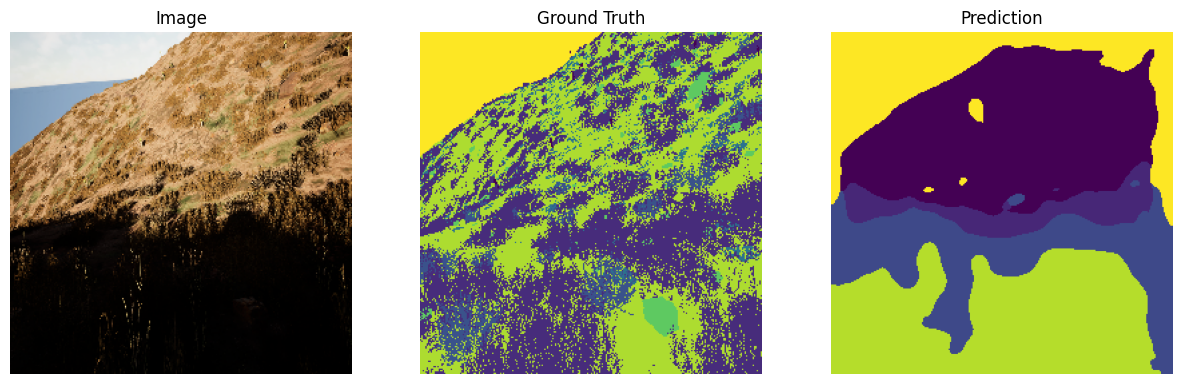

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(images, masks, preds, idx=0):
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(images[idx])
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ground Truth")
    plt.imshow(np.argmax(masks[idx], axis=-1))
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.imshow(np.argmax(preds[idx], axis=-1))
    plt.axis("off")

    plt.show()

visualize_sample(images, masks, preds)
